# EIGSEP Suspension and Horizon Modeling

Aaron Parsons

In [2]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import LightSource
from mayavi import mlab
# eigsep_terrain is available at https://github.com/AaronParsons/eigsep_terrain.git
from eigsep_terrain.marjum_dem import MarjumDEM as DEM
import eigsep_terrain as et
import linsolve
import scipy.ndimage as ndi
import os
import tqdm
mlab.init_notebook()

%matplotlib widget

ImportError: Initialization failed for vtkWebCore, not compatible with vtkmodules.vtkCommonCore

In [ ]:
m2ft = 5408 / 1652
ft2m = 1 / m2ft

In [3]:
CACHE_FILE = 'marjum_dem.npz'
CACHE_HORIZON_FILENAME = 'marjum_horizon_area.npz'

TETHER_MAX = 300 # m, absolute maximum for tether length; don't consider longer than this
H_MIN = 100 # m, minimum antenna height off ground
H_MAX = 150 # m, maximum antenna height off ground
THETA_MIN = np.deg2rad(20) # radians, minimum tether inclination angle
N_BINS = 256  # number of azimuthal bins to group pixels into for finding opposing tether points

dem = DEM(cache_file=CACHE_FILE)

In [4]:
def color_str2tup(s):
    r, g, b = s[0:2], s[2:4], s[4:6]
    return tuple(map(lambda x: int(x, base=16) / 255, (r, g, b)))

def plot_img(ax, data, res=dem.res, xlabel=True, ylabel=True,
             colorbar=False, cmap='terrain', erng=None, nrng=None, **kw):
    '''Plot maps with standard format.'''
    if nrng is None:
        nrng = (0, data.shape[0] * res)
    if erng is None:
        erng = (0, data.shape[1] * res)
    extent = erng + nrng
    im = ax.imshow(data, extent=extent, cmap=cmap, origin='lower', interpolation='nearest', **kw)
    if colorbar:
        plt.colorbar(im)
    if xlabel:
        ax.set_xlabel('East [m]')
    if ylabel:
        ax.set_ylabel('North [m]')

def find_neighboring_cliff_height(data, r_sus=200, res=dem.res):
    """d_sus: m, maximum suspension radius."""
    dker = int(np.around(r_sus / res))
    # find height of cliffs to either side (UL/DR, or UR/DL)
    mx00 = ndi.maximum_filter(data, size=(dker+1,dker+1), origin=(-dker//2,-dker//2))
    mx01 = ndi.maximum_filter(data, size=(dker+1,dker+1), origin=(-dker//2, dker//2))
    mx10 = ndi.maximum_filter(data, size=(dker+1,dker+1), origin=( dker//2,-dker//2))
    mx11 = ndi.maximum_filter(data, size=(dker+1,dker+1), origin=( dker//2, dker//2))
    mx00_11 = np.where(mx00 < mx11, mx00, mx11)
    mx01_10 = np.where(mx01 < mx10, mx01, mx10)
    mx = np.where(mx00_11 > mx01_10, mx00_11, mx01_10)  # best estimate of cliff heights to either side
    return mx

def dist(a, b):
    return np.linalg.norm(b - a)

def alt(a, b):
    return b[-1] - a[-1]

def az(a, b):
    return np.arctan2(b[1] - a[1], b[0] - a[0])

def filter_pixels(_n, _e, U, h=H_MIN, nb=5, npnts=350):
    '''Quick filter on whether points see to corner of map boundaries.'''
    _mask = np.ones(_n.shape, dtype='bool')
    n_bound = np.linspace(0, U.shape[0] - 1, nb)
    e_bound = np.linspace(0, U.shape[1] - 1, nb)
    _hs = h + U[_n, _e]
    for i in tqdm.tqdm(range(_n.size)):
        for _nc in (0, U.shape[0] - 1):
            _nis = np.around(np.linspace(_n[i], _nc, npnts)).astype(int)
            for _ec in e_bound:
                _eis = np.around(np.linspace(_e[i], _ec, npnts)).astype(int)
                if not np.any(U[_nis, _eis] > _hs[i]):
                    _mask[i] = 0
                    break
            if _mask[i] == 0: break
        if _mask[i] == 0: continue
        for _ec in (0, U.shape[1] - 1):
            _eis = np.around(np.linspace(_e[i], _ec, npnts)).astype(int)
            for _nc in n_bound:
                _nis = np.around(np.linspace(_n[i], _nc, npnts)).astype(int)
                if not np.any(U[_nis, _eis] > _hs[i]):
                    _mask[i] = 0
                    break
            if _mask[i] == 0: break
    return _mask

In [5]:
SURVEY_PNTS = {
    # Survey points from July 2024 site
    #'0724 A': '+039.241127, -113.392966, 1748',  # ~3m south of antenna 1
    #'0724 B': '+039.239895, -113.395416, 1728',  # ~3m south of antenna 2
    #'0724 O': '+039.241514, -113.395236, 1804',  # outlook, west canyon
    #'0724 W': '+039.241107, -113.395233, 1790',  # anchor, west
    #'0724 E': '+039.240712, -113.393846, 1776',  # anchor, east
    '10/24 Vivaldi North': '+039.248213, -113.403151, 1675',  # photo 2.5 m S of north vivaldi on ground
    '10/24 Vivaldi South': '+039.247045, -113.402732, 1658',  # photo 2.5 m S of south vivaldi on ground
    '10/24 Camp'         : '+039.246265, -113.403291, 1685',  # camp position; height suspect; 13 deg az, 30.5 deg alt to raised vivaldi
    #'10/24 Survey Point1': '+039.247660, -113.402828, 1639',  # looking at raised vivaldi, 11 deg az, 72.6 deg alt
    '10/24 Survey Point2': '+039.247681, -113.403277, 1650',  # cabin? looking at raised vivaldi, 64 deg az, 61.7 deg alt
    #'10/24 Survey Point3': '+039.247925, -113.402930, 1686',  # looking at mistic, 13 deg az, 14.9 deg alt
    '10/24 Survey Point4': '+039.248263, -113.403172, 1686',  # near north vivaldi, looking at mistic, 27 deg az, 20.4 deg alt
    '10/24 Survey Point5': '+039.248197, -113.403130, 1675',  # near north vivaldi, looking at raised vivaldi , 121 deg az, 55.6 deg alt
    '10/24 Survey Point6': '+039.248204, -113.403095, 1688',  # near north vivaldi, looking at cabin, 190 deg az, -0.9 deg alt
    #'10/24 Survey Point7': '+039.248166, -113.403837, 1690',  # looking at cabin, 145 deg az, -23.7 deg alt
    #'10/24 Survey Point8': '+039.248263, -113.403842, 1707',  # looking at transmitter, 140 deg az, -20.1 deg alt
    #'10/24 Survey Point9': '+039.248307, -113.403839, 1723',  # looking at mistic?, 59 deg az, -2.4 deg alt
    #'10/24 Survey Poin10': '+039.248308, -113.403839, 1719',  # looking at mistic E anchor, 67 deg az, +5.6 deg alt
    #'10/24 Survey Poin11': '+039.248359, -113.403901, 1711',  # looking at mistic W anchor, 25 deg az, +12.9 deg alt
    '10/24 Survey Poin12': '+039.249200, -113.403442, 1752',  # looking at mistic E anchor from W anchor, 123 deg az, +1.5 deg alt
    '10/24 Survey Poin13': '+039.248438, -113.401927, 1812',  # looking at mistic base from E anchor, 289 deg az, -27.3 deg alt
    '10/24 Survey Poin14': '+039.249192, -113.403446, 1766',  # looking at mistic base from W anchor, 129 deg az, -37.3 deg alt
}


'''elmo tree': '+039.24904, -113.40486, 1885',  # elmo tree'''
'''monster elev: 6167 ft = 1883 m'''
'''beaker  elev: 6111 ft = 1866 m < 2E elev = 1885'''
'''grover  elev: 6387 ft = 1951 m'''
dem.add_survey_points(SURVEY_PNTS, survey_offset=np.array([-25, 50, 0]))
# interpolate an estimated point for where the July 2024 antenna was suspended
#dem['0724 P'] = dem.interp_alt(*((dem['0724 W'] + dem['0724 E'])[:2] / 2), return_vec=True)

# Known sites
dem['1P'] = np.array([1648, 2024, 1796])  # Site 1, index 0, 114 m off ground
dem['1E'] = dem.interp_alt(1790, 1915, return_vec=True)  # Site 1, East anchor
dem['1W'] = dem.interp_alt(1518, 2124, return_vec=True)  # Site 1, West anchor

dem['2P'] = np.array([1740, 2264, 1833])  # Site 2, index 2, 124 m off ground
dem['2E'] = dem.interp_alt(1920, 2240, return_vec=True)  # Site 2, East anchor
dem['2W'] = dem.interp_alt(1538, 2291, return_vec=True)  # Site 2, West anchor

In [6]:
for site in (1, 2):
    for pnt in ('East', 'Platform', 'West'):
        _lat, _lon, _alt = dem.enu_to_latlon(dem[f'{site}{pnt[0]}'])
        print(f"Site {site}, {pnt:>8}: latitude={_lat:9.6f}, longitude={_lon:9.6f}, altitude={_alt:4.0f} m")
    print()

Site 1,     East: latitude=39.246717, longitude=-113.401016, altitude=1847 m
Site 1, Platform: latitude=39.247699, longitude=-113.402660, altitude=1800 m
Site 1,     West: latitude=39.248600, longitude=-113.404166, altitude=1843 m

Site 2,     East: latitude=39.249643, longitude=-113.399510, altitude=1885 m
Site 2, Platform: latitude=39.249860, longitude=-113.401594, altitude=1837 m
Site 2,     West: latitude=39.250103, longitude=-113.403934, altitude=1889 m



## Determine Antenna Height

In this section, we determine the antenna height across the map that places all terrain formations at a distance 100 m from the antenna.

This is done by solving the quadratic equation for height above the ground, $h$, as
\begin{equation}
\left(h - z(\vec r)\right)^2 + \left|\vec r\right|^2\ge h_0^2,
\end{equation}
where $h_0$ is the specified (100 m) distance requirement, $\vec r$ is the 2D (east/north) displacement vector 
from the location in question, and $z(\vec r)$ is the terrain height as a function of displacement.

Algebraic manipulation gives the closed form solution:
\begin{equation}
h = {\rm max}\left(z(\vec r) + \sqrt{h_0^2-\left|\vec r\right|^2}\right),
\end{equation}
for $\left|\vec r\right|\le h_0$.

In [7]:
f = 32  # starting decimation
E, N, U = dem.get_tile(mesh=False, decimate=f)
res = dem.res * f
# pick pixels that have opposing cliffs above a certain height
mx = find_neighboring_cliff_height(U, res=res)
mask1 = np.where(mx - U > H_MIN)
print(f"Downselected from {U.size} px to {mask1[0].size} px at decimation={f}")

Downselected from 47000 px to 3804 px at decimation=32


In [8]:
# Filter out pixels that see to the edge of the map
_n, _e = mask1
_mask = filter_pixels(_n, _e, U)
mask2 = (_n[_mask], _e[_mask])
print(f"Downselected from {mask1[0].size} px to {mask2[0].size} px at decimation={f}")

100%|███████████████████████████████████████████████████████████████████████| 3804/3804 [00:01<00:00, 2774.65it/s]

Downselected from 3804 px to 385 px at decimation=32


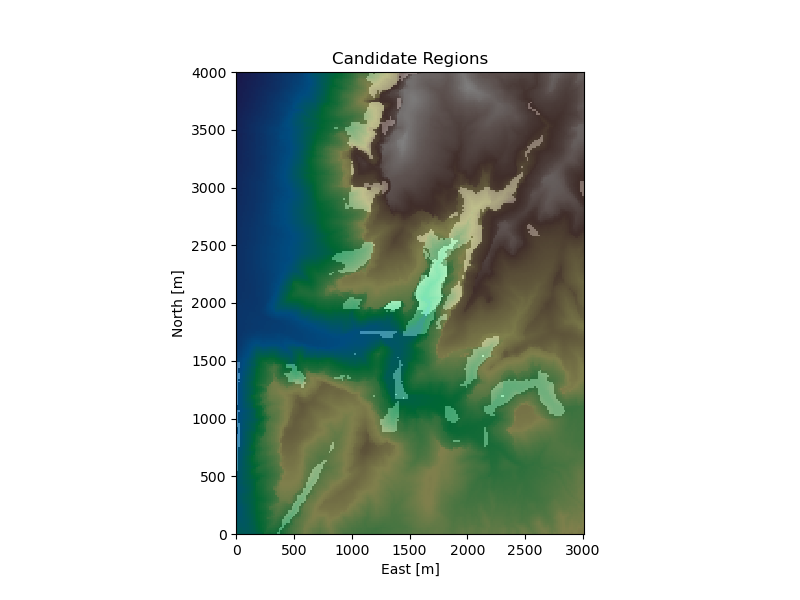

In [9]:
fig, axes = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(8, 6))
res = dem.res * f
plot_img(axes, U, res=res)
_maskview = np.zeros_like(U)
for m in (mask1, mask2):
    _maskview[m[0], m[1]] += 1
plot_img(axes, _maskview, cmap='gray', alpha=0.5, res=res)
_ = plt.title('Candidate Regions')

In [10]:
# Upgrade resolution and refine pixel selection
f_prev = f
mask_prev = mask2

for f_next in (8,):
    f_step = f_prev // f_next
    f_prev = f_next
    subdiv = np.arange(f_step)
    _de, _dn = np.meshgrid(subdiv, subdiv)
    mask_next = (np.ravel(f_step * mask_prev[0][:,None,None] + _dn), np.ravel(f_step * mask_prev[1][:,None,None] + _de))
    print(f"Upsampled from {mask_prev[0].size} px to {mask_next[0].size} px at decimation={f_next}")
    mask_prev = mask_next
    
    E, N, U = dem.get_tile(mesh=False, decimate=f_next)
    _n, _e = mask_next
    hs = dem.zone_of_avoidance_height(E[_e], N[_n], r_zoa=H_MIN)
    _mask = np.where(hs < H_MAX)[0]
    _n, _e, hs = (_n[_mask], _e[_mask], hs[_mask])
    
    # quick filter on whether points see to corner of map boundaries
    _mask = filter_pixels(_n, _e, U, h=H_MIN)
    mask_next = (_n[_mask], _e[_mask], hs[_mask])
    print(f"Downselected from {mask_prev[0].size} px to {mask_next[0].size} px at decimation={f_next}")
    mask_prev = mask_next

Upsampled from 385 px to 6160 px at decimation=8


100%|███████████████████████████████████████████████████████████████████████| 1259/1259 [00:01<00:00, 1123.97it/s]

Downselected from 6160 px to 1084 px at decimation=8


In [11]:
# Make sure all of these sites have candidate anchor positions
_n, _e, _h = mask_next
_mask = []
for i in tqdm.tqdm(range(_n.size)):
    try:
        anchors = dem.find_anchors(E[_e[i]], N[_n[i]], U[_n[i],_e[i]] + _h[i], n_anchors=2, r_anchor_max=TETHER_MAX, min_angle=THETA_MIN, decimate=f)
        assert len(anchors) > 0
        for a in anchors:
            assert not np.isnan(a[0]) and not np.isnan(a[1])
            assert not np.isinf(a[0]) and not np.isinf(a[1])
        _mask.append(1)
    except(IndexError, AssertionError):
        _mask.append(0)
_mask = np.array(_mask, dtype=bool)
mask5 = (_n[_mask], _e[_mask], _h[_mask])
print(f"Downselected from {mask_next[0].size} px to {mask5[0].size} px")

/home/aparsons/miniforge3/envs/mayavi/lib/python3.10/site-packages/eigsep_terrain/dem.py:187: RuntimeWarning: invalid value encountered in multiply
  anchors_e = e0 + r_anchors * np.sin(az_anchors)
100%|███████████████████████████████████████████████████████████████████████| 1084/1084 [00:00<00:00, 2423.60it/s]

Downselected from 1084 px to 43 px


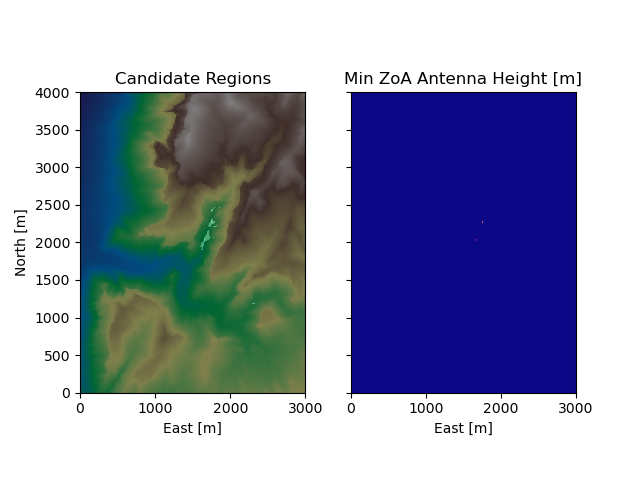

In [12]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
res = dem.res * f_next
plot_img(axes[0], U, res=res)
_maskview = np.zeros_like(U)
heights = np.zeros_like(U)
heights[mask5[0], mask5[1]] = mask5[2]
for m in (mask_next, mask5):
    _maskview[m[0], m[1]] += 1
plot_img(axes[0], _maskview, cmap='gray', alpha=0.5, res=res)
plot_img(axes[1], heights, res=res, cmap='plasma', ylabel=False, vmin=H_MIN, vmax=H_MAX)
axes[0].set_title("Candidate Regions")
_ = axes[1].set_title("Min ZoA Antenna Height [m]")

## Compute Airplane Visibility

In this section, we compute the distance versus azimuth angle at which an airplane flying at a height of 10 km could be seen above the surrounding terrain. This is used to select well-shielded areas for the antennas.

We need some math to compute the distance at which an airplane is visible given an obstruction at 
a certain angle above the horizon, including the effect of earth curvature.

We solve for the distance $d$ by constructing a triangle with vertices at the current location (1), the center of the earth (2), and the airplane (3), with angles $\theta_1$, $\theta_2$, and $\theta_3$, respectively.
Assuming that the current location is $R_\oplus$ from the center of the earth and
that the airplane is $R_\oplus+h$ from it (where $h$ is 10 km), we can use the law of sines to say
\begin{equation}
\frac{\sin\theta_1}{R_\oplus+h}=\frac{\sin\theta_3}{R_\oplus}.
\end{equation}
We also have that $\theta_1=\frac\pi2+\alpha$, where $\alpha$ is the angle above the horizon, 
and $\theta_2=\frac{d}{R_\oplus}$. Finally, using the internal sum of angles in a triangle, we have
$$\theta_3 = \frac\pi2-\alpha-\frac{d}{R_\oplus}.$$
Setting this equal to the expression for $\theta_3$ we have above, we get:
\begin{equation}
\frac\pi2-\alpha-\frac{d}{R_\oplus} = \sin^{-1}\left(\frac{R_\odot}{R_\odot+h} \sin\left(\frac\pi2+\alpha\right)\right),
\end{equation}
and this can be used to solve for $d$.

In [13]:
# Calculate the horizon angle of the terrain surround the antenna
# This can be expensive, so we cache the result to reuse.
harea = np.ones_like(U) * 1e5 # km^2
hs = np.zeros_like(U)
if not os.path.exists(CACHE_HORIZON_FILENAME):
    _n, _e, _h = mask5
    for i in tqdm.tqdm(range(_n.size)):
        # XXX the re-use of crds here can put horizon points out of order
        horizon_angles, crds = dem.calc_horizon(E[_e[i]], N[_n[i]], _h[i] + U[_n[i],_e[i]], crds=crds)
        vis_dist = et.utils.horizon_angle_to_distance(horizon_angles, 10e3)
        _harea = np.sum(np.pi * vis_dist ** 2 / vis_dist.size) / 1e6 # km^2
        harea[_n[i], _e[i]] = _harea
    np.savez(CACHE_HORIZON_FILENAME, e=E[_e], n=N[_n], h=_h, u=_h + U[_n,_e], horizon_area=harea[_n,_e])
else:
    npz = np.load(CACHE_HORIZON_FILENAME)
    n_px, e_px = dem.m2px(npz['n'], npz['e'], res=res)
    harea[n_px, e_px] = npz['horizon_area']
    hs[n_px, e_px] = npz['h']

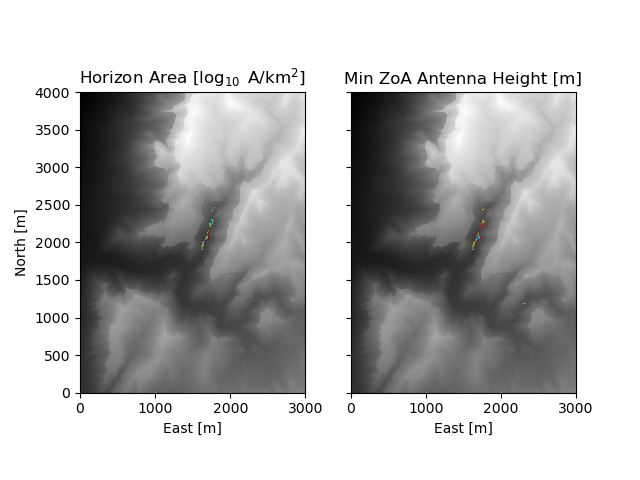

In [14]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
plot_img(axes[0], U, res=res, cmap='gray')
plot_img(axes[0], np.log10(np.where(harea == 1e5, np.nan, harea)), res=res, vmax=5, cmap='jet', alpha=0.5)
axes[0].set_title('Horizon Area [$\log_{10}$ A/km$^2$]')
plot_img(axes[1], U, res=res, cmap='gray', ylabel=False)
plot_img(axes[1], np.where(hs == 0, np.nan, hs), res=res, vmax=H_MAX, vmin=H_MIN, cmap='jet', alpha=0.5, ylabel=False)
_ = axes[1].set_title("Min ZoA Antenna Height [m]")

In [15]:
# sort remaining pixels by competitiveness
MAX_HORIZON_AREA = 40e3  # km^2
_mask = np.where(np.logical_and(npz['horizon_area'] < MAX_HORIZON_AREA, npz['h'] < H_MAX))[0]
es, ns, us, hs = npz['e'][_mask], npz['n'][_mask], npz['u'][_mask], npz['h'][_mask]
harea = npz['horizon_area'][_mask]
inds = np.argsort(harea)
es, ns, us, hs =  es[inds], ns[inds], us[inds], hs[inds]

In [16]:
# solve for good tether points around candidate location
# Select a site to look at
PARTIAL_EXTEND = 20 # m
#i = 0
e0, n0, u0 = dem['0P'] = dem['1P'] #= np.array([es[i], ns[i], us[i]])
#h = hs[i]
# Find tether points
anchors, boundaries = dem.find_anchors(e0, n0, u0, n_anchors=2, r_anchor_max=TETHER_MAX, min_angle=THETA_MIN, boundary=True)
dem['0E'] = anc_e = dem.interp_alt(*anchors[0], return_vec=True)
dem['0W'] = anc_w = dem.interp_alt(*anchors[1], return_vec=True)

for key in ('0', '1', '2'):
    pltfm = dem[key + 'P']
    h = pltfm[2] - dem.interp_alt(*pltfm[:2])
    print(f'Location {key}: {pltfm[0]: 3.0f} m East, {pltfm[1]: 3.0f} m North, {pltfm[2]: 3.0f} m Up ({h: 3.0f} m off ground)')
    for pkey in ('E', 'W'):
        pnt = dem[key + pkey]
        print(f"Anchor {key + pkey}: ({pnt[0]: 3.0f} m E, {pnt[1]: 3.0f} m N), L_tight = {dist(pltfm, pnt): 3.0f} m")
        print(f"                                   L_full_extend = {dist(pltfm - np.array([0, 0, h]), pnt): 3.0f} m")
        h_partial_extend = h - (pltfm[2] - (pnt[2] - np.sqrt((dist(pltfm, pnt) + PARTIAL_EXTEND)**2 - (pnt[0] - pltfm[0])**2 - (pnt[1] - pltfm[1])**2)))
        print(f"                                  {PARTIAL_EXTEND: 3.0f} m extension => {h_partial_extend: 3.0f} m off ground")
        print(h_partial_extend)
        #print(f"Anchor {pkey}: ({pnt[0]: 3.0f} m E, {pnt[1]: 3.0f} m N), L_tight = {dist(pltfm, pnt): 3.0f} m, L_extend = {dist(pltfm - np.array([0, 0, h]), pnt): 3.0f} m")
    print()

Location 0:  1648 m East,  2024 m North,  1796 m Up ( 114 m off ground)
Anchor 0E: ( 1829 m E,  1869 m N), L_tight =  251 m
                                   L_full_extend =  307 m
                                   20 m extension =>  64 m off ground
64.18672081749992
Anchor 0W: ( 1471 m E,  2175 m N), L_tight =  245 m
                                   L_full_extend =  301 m
                                   20 m extension =>  64 m off ground
63.5671683051994

Location 1:  1648 m East,  2024 m North,  1796 m Up ( 114 m off ground)
Anchor 1E: ( 1790 m E,  1915 m N), L_tight =  185 m
                                   L_full_extend =  241 m
                                   20 m extension =>  61 m off ground
60.93934603806633
Anchor 1W: ( 1518 m E,  2124 m N), L_tight =  170 m
                                   L_full_extend =  227 m
                                   20 m extension =>  62 m off ground
61.96731073712249

Location 2:  1740 m East,  2264 m North,  1833 m Up ( 124 m off

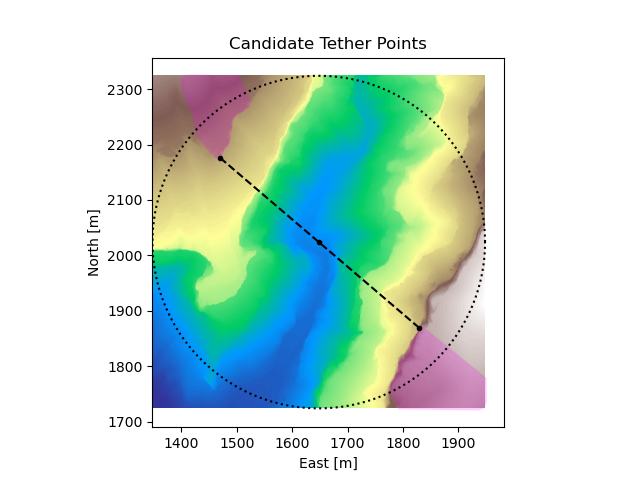

In [17]:
fig, ax = plt.subplots()
e1, n1 = anchors[0]
e2, n2 = anchors[1]
erng = (e0 - TETHER_MAX, e0 + TETHER_MAX)
nrng = (n0 - TETHER_MAX, n0 + TETHER_MAX)
_E, _W, _U = dem.get_tile(erng_m=erng, nrng_m=nrng, mesh=True)
plot_img(ax, _U, erng=erng, nrng=nrng)
plt.plot([e0, e1, e2], [n0, n1, n2], 'k.')
plt.plot([e1, e2], [n1, n2], 'k--')
th = np.linspace(0, 2 * np.pi, 200)
_r = TETHER_MAX
plt.plot(e0 + _r * np.cos(th), n0 + _r * np.sin(th), 'k:')

for cnt in range(len(anchors)):
    ax.fill(boundaries[cnt, :, 0], boundaries[cnt, :, 1], 'magenta', alpha=0.2)
_ = plt.title('Candidate Tether Points')

In [18]:
# Calculate the horizon angle of the terrain surround the antenna
horizon_angles = {}
horizon_pnts = {}
for k in ('0', '1', '2'):
    pnt = dem[k + 'P']
    horizon_angles[k], horizon_pnts[k] = dem.calc_horizon(*pnt)
    vis_dist = et.utils.horizon_angle_to_distance(horizon_angles[k], 10e3)
    print(f'Viewable Airplane Area, Site {k}: {np.sum(np.pi * vis_dist ** 2 / vis_dist.size) / 1e6:3.0f} km^2')

Viewable Airplane Area, Site 0: 18679 km^2
Viewable Airplane Area, Site 1: 18679 km^2
Viewable Airplane Area, Site 2: 19986 km^2


In [25]:
horizon_pnts.keys()

dict_keys(['0', '1', '2'])

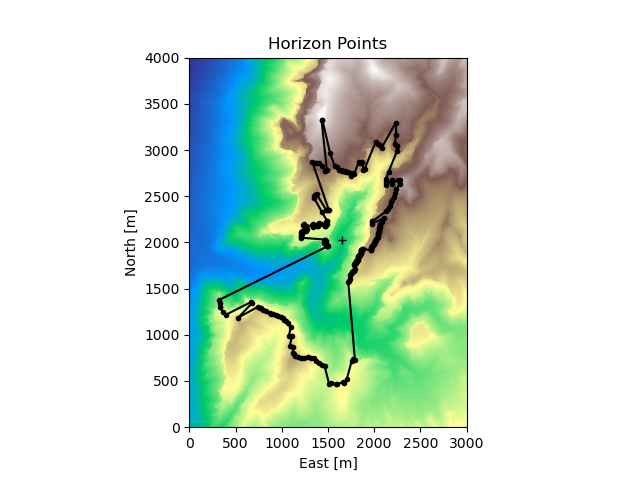

In [27]:
fig, ax = plt.subplots()
plot_img(ax, dem.data, dem.res)
#for k in horizon_angles.keys():
for k in ['1']:
    #color = ax._get_lines.get_next_color()
    color = 'k'
    plt.plot(horizon_pnts[k][1], horizon_pnts[k][0], '.-', color=color)
    plt.plot([dem[k + 'P'][0]], [dem[k + 'P'][1]], '+', color=color)
_ = plt.title('Horizon Points')

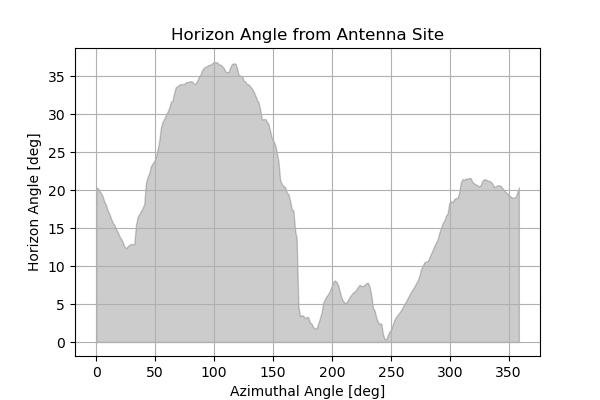

In [29]:
plt.figure(figsize=(6,4))
plt.title('Horizon Angle from Antenna Site')
#for k in horizon_angles.keys():
for k in ['1']:
    #color = ax._get_lines.get_next_color()
    color = 'k'
    plt.fill_between(np.linspace(0, 360, horizon_angles[k].size, endpoint=False), np.rad2deg(horizon_angles[k]), 0,
                     color=color, alpha=0.2, label=k)
#plt.legend()
plt.xlabel('Azimuthal Angle [deg]')
plt.ylabel('Horizon Angle [deg]')
_ = plt.grid()

In [21]:
e0, n0, u0 = dem['1P']
#n0 += 200
#n0 -= 300
view_rng, view_dec = 600, 1 # m
E, N, U = dem.get_tile(erng_m=(e0 - view_rng, e0 + view_rng), nrng_m=(n0 - view_rng, n0 + view_rng), decimate=view_dec)

if True:  # enable 3d interactive plot
    TAUPE = color_str2tup('b7c0c9')
    mlab.figure(size=(2*400, 2*320), bgcolor=TAUPE)
    s = mlab.surf(E.T, N.T, U.T, warp_scale=1, vmin=1500, colormap='copper')
    #mlab.outline()
    mlab.axes(xlabel='E', ylabel='N', zlabel='U')
    #for k in horizon_angles.keys():
    #for k in ('1', '2'):
    for k in ('1'):
        line1 = np.array([dem[k+'E'], dem[k+'P']])
        line2 = np.array([dem[k+'W'], dem[k+'P']])
        line3 = np.array([dem.interp_alt(*dem[k+'P'][:2], return_vec=True), dem[k+'P']])
        mlab.plot3d(line1[:,0], line1[:,1], line1[:,2], tube_radius=1)
        mlab.plot3d(line2[:,0], line2[:,1], line2[:,2], tube_radius=1)
        mlab.plot3d(line3[:,0], line3[:,1], line3[:,2], tube_radius=1)
        mlab.points3d(*dem[k+'P'], color=(1, 0, 1), opacity=0.3, scale_factor=2*H_MIN, resolution=64)
    #mlab.view(250, 90)
    mlab.view(90, 0)
else:
    s = None
s

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02\x80\x08\x02\x00\x00\x00\xeby\x8be\x…

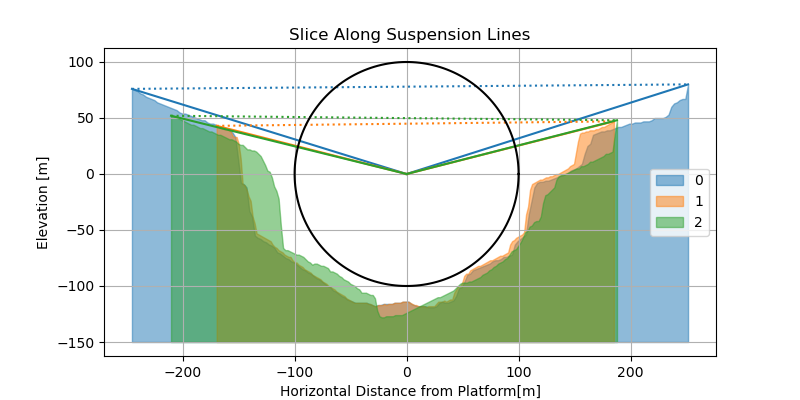

In [22]:
fig, axes = plt.subplots(ncols=1, figsize=(8, 4))
for cnt, k in enumerate(horizon_angles.keys()):
    plot_e = np.linspace(dem[k+'W'][0], dem[k+'E'][0], 200)
    plot_n = np.linspace(dem[k+'W'][1], dem[k+'E'][1], 200)
    plot_r = np.linspace(-dist(dem[k+'W'], dem[k+'P']), dist(dem[k+'E'], dem[k+'P']), 200)
    color = axes._get_lines.get_next_color()
    axes.fill_between(plot_r, dem.interp_alt(plot_e, plot_n) - dem[k+'P'][-1], -150, color=color, alpha=0.5, label=k)
    axes.plot([plot_r[0], plot_r[-1]], [dem[k+'W'][-1] - dem[k+'P'][-1], dem[k+'E'][-1] - dem[k+'P'][-1]], ':', color=color)
    axes.plot([plot_r[0], 0], [dem[k+'W'][-1] - dem[k+'P'][-1], 0], '-', color=color)
    axes.plot([0, plot_r[-1]], [0, dem[k+'E'][-1] - dem[k+'P'][-1]], '-', color=color)
    th = np.linspace(0, 2 * np.pi, 200)
axes.plot(H_MIN * np.cos(th), H_MIN * np.sin(th), 'k-')
axes.grid()
axes.legend(loc='best')
axes.set_xlabel('Horizontal Distance from Platform[m]')
axes.set_ylabel('Elevation [m]')
axes.set_aspect('equal')
_ = axes.set_title('Slice Along Suspension Lines')

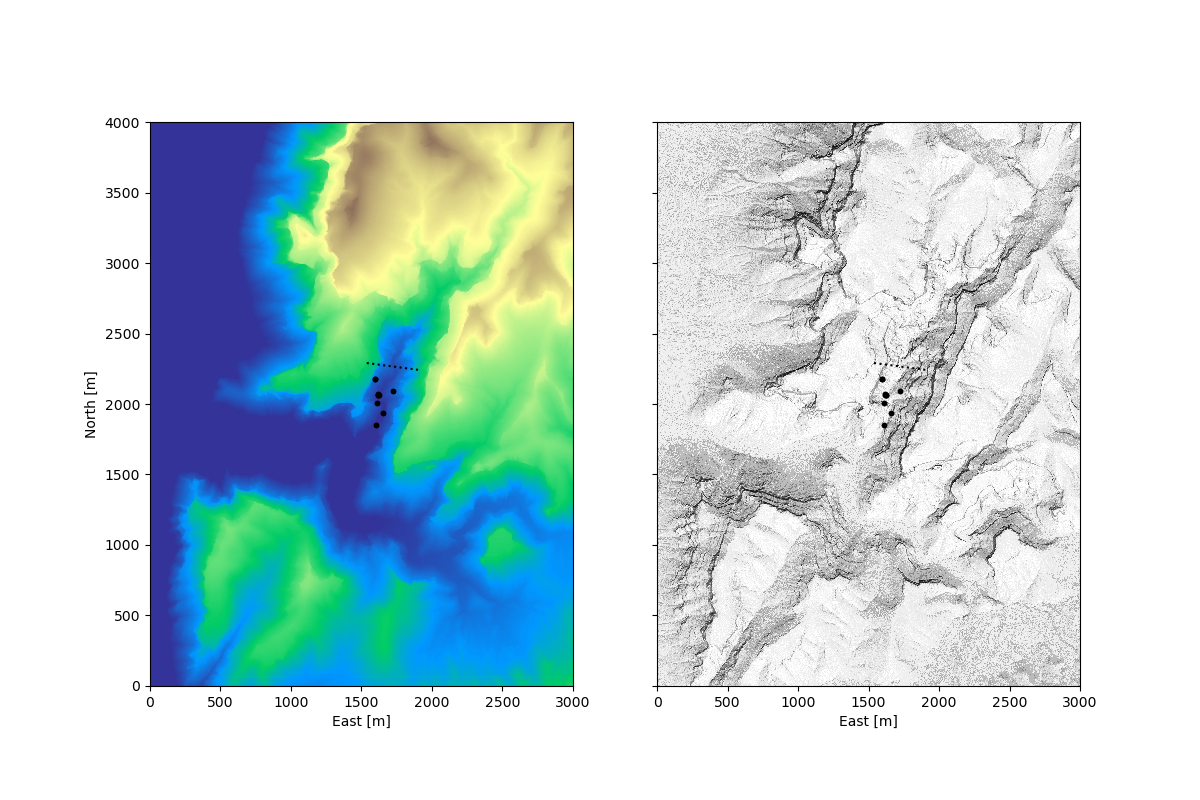

In [23]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 8))
_, _, data = dem.get_tile(decimate=2, mesh=False)
plot_img(axes[0], data, vmin=1670, vmax=2500, res=dem.res * 2)
ls = LightSource(azdeg=15, altdeg=65)
plot_img(axes[1], ls.hillshade(data, vert_exag=1), cmap='gray', ylabel=False, res=dem.res * 2)

for ax in axes:
    ax.plot(plot_e, plot_n, 'k:')

for k, (_e, _n, _u) in dem.items():
    if not k.startswith('10/24'): continue
    for ax in axes:
        ax.plot([_e], [_n], 'k.')
        ax.plot([_e], [_n], 'k.')

## Suspension Tethers

In this section we consider weights and lengths suspending antennas.

The choice of minimum suspension angle impacts where anchors can be placed, but as suspension angles get flatter, increased force is required to hold an antenna platform of a fixed weight:
\begin{equation}
F_{\rm tension} = \frac{mg}{N_{\rm tethers}\sin\phi},
\end{equation}
where $N_{\rm tethers}$ is the number of tethers holding the antenna platform, and $\phi$ is the suspension angle.

### Rope Specs

We've been using 3/16" Kevlar core rope (https://qualitynylonrope.com/product/3-16-kevlar-cord-with-polyester-jacket-black), which has a breaking load of 1150 lbs and a weight of 11.72 lbs / 1000 ft.

In [24]:
units = 'kg'
TENSION_MAX = 520  # kg
ROPE_WGT = 5.3 / 304  # kg / m

platform_wgt = 35 # kg

tensions = {}
for k in horizon_angles.keys():
    rope_wgt = ROPE_WGT * (dist(dem[k+'W'], dem[k+'P']) + dist(dem[k+'E'], dem[k+'P']))
    tiedown_wgt = ROPE_WGT * (dem[k+'P'][-1] - dem.interp_alt(*dem[k+'P'][:2])) + 0.25 * platform_wgt
    total_wgt = platform_wgt + rope_wgt + tiedown_wgt
    
    phi_w = np.arcsin(alt(dem[k+'P'], dem[k+'W']) / dist(dem[k+'W'], dem[k+'P']))
    phi_e = np.arcsin(alt(dem[k+'P'], dem[k+'E']) / dist(dem[k+'E'], dem[k+'P']))
    
    d = {}
    d['Tw*sw + Te*se'] = total_wgt
    d['Tw*cw - Te*ce'] = 0
    
    consts = {
        'sw': np.sin(phi_w),
        'se': np.sin(phi_e),
        'cw': np.cos(phi_w),
        'ce': np.cos(phi_e),
    }
    
    ls = linsolve.LinearSolver(d, **consts)
    tensions[k] = ans = ls.solve()
    print(f"Site {k}: Tensions as fraction of max: {100 * ans['Tw'] / TENSION_MAX:5.2f} % (West), {100 * ans['Te'] / TENSION_MAX:5.2f} % (East)")
    print(f"Site {k}: Incination to anchors: {np.rad2deg(phi_w): 3.0f} deg W, {np.rad2deg(phi_e): 3.0f} deg E")
    print()

Site 0: Tensions as fraction of max: 16.62 % (West), 16.67 % (East)
Site 0: Incination to anchors:  18 deg W,  19 deg E

Site 1: Tensions as fraction of max: 19.67 % (West), 19.67 % (East)
Site 1: Incination to anchors:  15 deg W,  15 deg E

Site 2: Tensions as fraction of max: 20.19 % (West), 20.24 % (East)
Site 2: Incination to anchors:  14 deg W,  15 deg E



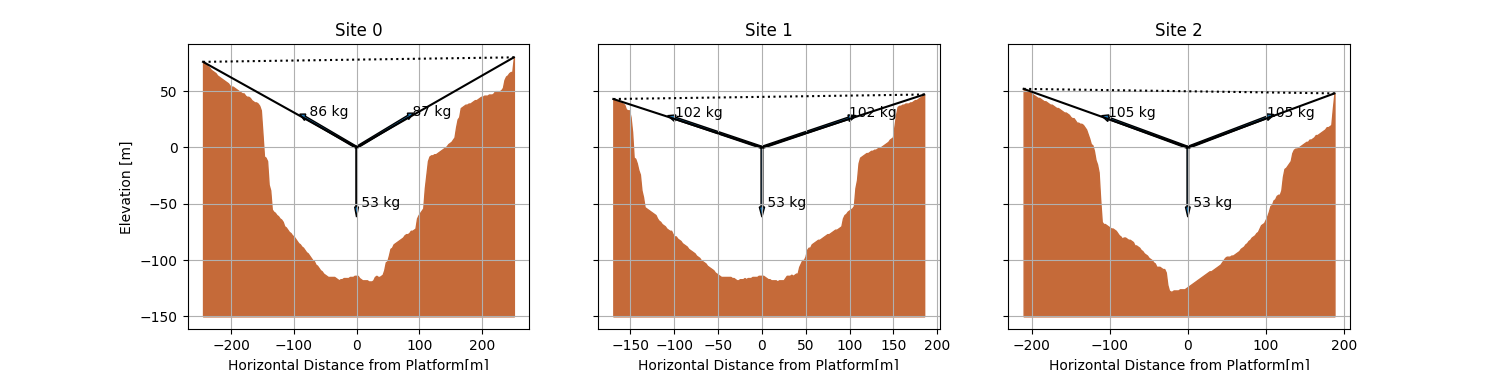

In [28]:
fig, axes = plt.subplots(ncols=len(horizon_angles), sharey=True, figsize=(5 * len(horizon_angles), 3.7))
for cnt, k in enumerate(horizon_angles.keys()):
    phi_w = np.arcsin(alt(dem[k+'P'], dem[k+'W']) / dist(dem[k+'W'], dem[k+'P']))
    phi_e = np.arcsin(alt(dem[k+'P'], dem[k+'E']) / dist(dem[k+'E'], dem[k+'P']))
    ans = tensions[k]
    plot_e = np.linspace(dem[k+'W'][0], dem[k+'E'][0], 200)
    plot_n = np.linspace(dem[k+'W'][1], dem[k+'E'][1], 200)
    plot_r = np.linspace(-dist(dem[k+'W'], dem[k+'P']), dist(dem[k+'E'], dem[k+'P']), 200)
    color = 'k'
    #axes.fill_between(plot_r, dem.interp_alt(plot_e, plot_n) - dem[k+'P'][-1], -150, color=color, alpha=0.5, label=k)
    axes[cnt].fill_between(plot_r, dem.interp_alt(plot_e, plot_n) - dem[k+'P'][-1], -150, color=color_str2tup('c56a39'))
    axes[cnt].plot([plot_r[0], plot_r[-1]], [dem[k+'W'][-1] - dem[k+'P'][-1], dem[k+'E'][-1] - dem[k+'P'][-1]], ':', color=color)
    axes[cnt].plot([plot_r[0], 0], [dem[k+'W'][-1] - dem[k+'P'][-1], 0], '-', color=color)
    axes[cnt].plot([0, plot_r[-1]], [0, dem[k+'E'][-1] - dem[k+'P'][-1]], '-', color=color)
    axes[cnt].arrow(0, 0, -ans['Tw'] * np.cos(phi_w), ans['Tw'] * np.sin(phi_w), width=2)
    axes[cnt].text(-ans['Tw'] * np.cos(phi_w), 1 + ans['Tw'] * np.sin(phi_w), f'{ans["Tw"]:3.0f} {units}', fontsize=10)
    axes[cnt].arrow(0, 0,  ans['Te'] * np.cos(phi_e), ans['Te'] * np.sin(phi_e), width=2)
    axes[cnt].text( ans['Te'] * np.cos(phi_e), 1 + ans['Te'] * np.sin(phi_w), f'{ans["Te"]:3.0f} {units}', fontsize=10)
    axes[cnt].arrow(0, 0, 0, -total_wgt, width=2)
    axes[cnt].text(1, -total_wgt, f'{total_wgt:3.0f} {units}', fontsize=10)
    axes[cnt].grid()
    axes[cnt].set_xlabel('Horizontal Distance from Platform[m]')
    axes[cnt].set_title(f'Site {k}')
_ = axes[0].set_ylabel('Elevation [m]')
#axes.set_aspect('equal')

In [43]:
healpy.mollview?

Signature:
healpy.mollview(
    map=None,
    fig=None,
    rot=None,
    coord=None,
    unit='',
    xsize=800,
    title='Mollweide view',
    nest=False,
    min=None,
    max=None,
    flip='astro',
    remove_dip=False,
    remove_mono=False,
    gal_cut=0,
    format='%g',
    format2='%g',
    cbar=True,
    cmap=None,
    badcolor='gray',
    bgcolor='white',
    notext=False,
    norm=None,
    hold=False,
    reuse_axes=False,
    margins=None,
    sub=None,
    nlocs=2,
    return_projected_map=False,
    alpha=None,
)
Docstring:
Plot a healpix map (given as an array) in Mollweide projection.

Parameters
----------
map : float, array-like or None
  An array containing the map, supports masked maps, see the `ma` function.
  If None, will display a blank map, useful for overplotting.
fig : int or None, optional
  The figure number to use. Default: create a new figure
rot : scalar or sequence, optional
  Describe the rotation to apply.
  In the form (lon, lat, psi) (unit: degr

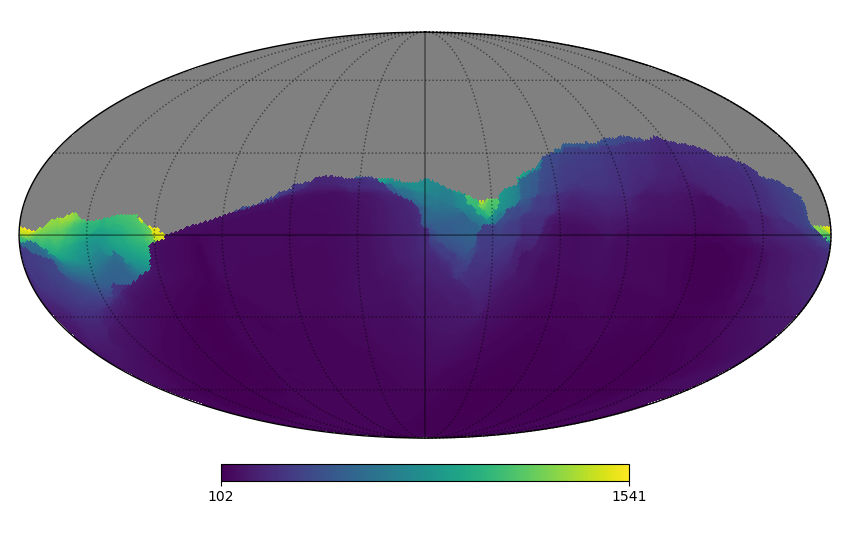

In [46]:
npz = np.load('horizon_model.npz')
import healpy
healpy.mollview(npz['r'], rot=(90,0,0), flip='astro', title=None, notext=True)
healpy.graticule(dpar=30, dmer=30, color='k', alpha=0.5, local=True)